## Proper Motion Use Case

This case identifies and extracts the Position and associated Proper Motion data from the sample file and plots them. 

In [1]:
import sys
import os
from rama.reader import Reader
from rama.reader.votable import Votable
from rama.models.measurements import Position, ProperMotion

sys.path.append('../utils')
from printutils import *

infile = './data/vizier_propermotion.avot'

### Load Data - find Position and ProperMotion instances

Note: the interface will return all instances of the specified type in a List.  We choose the first (and only) set which contains the column data.  If there were others, we would need more context to select the desired sets.

In [2]:
doc = Reader( Votable(infile) )
positions = doc.find_instances(Position)[0]
motions   = doc.find_instances(ProperMotion)[0]


Can't apply adapter: Longitude instances require units equivalent to 'rad', so cannot set it to 'arcsec / yr'.


### High Level content summary


In [3]:
print("Number of Records: {}".format( positions.cardinality ))
print("  o Position - type = {}".format( get_type_name(positions)))
print("  o ProperMotion - type = {}".format( get_type_name(motions)))
print("")
print("Position Coordinate.. auto-converted to AstroPy SkyCoord.")
print("  o Position.coord - type = {}".format( get_type_name(positions.coord)))
print("  o Position.coord - frame = {}".format( positions.coord.frame.name.upper()))
print("  o Position.coord - equinox = {}".format( positions.coord.equinox))
print("  o Position.coord - unit = {}".format( positions.coord.ra.unit))
print("")
print("Proper Motion")
print("  o ProperMotion.coord - type = {}".format( get_type_name(motions.coord)))
print("  o ProperMotion.coord.lon - type = {}".format( get_type_name(motions.coord.lon)))
print("  o ProperMotion.coord.lon.unit = {}".format( motions.coord.lon.unit))
print("  o ProperMotion.coord.lat - type = {}".format( get_type_name(motions.coord.lat)))
print("  o ProperMotion.coord.lat.unit = {}".format( motions.coord.lat.unit))
print("")
print(" Detailed example")
print("    " + measure_toString( positions.unroll()[0]))
print("    " + measure_toString( motions.unroll()[0]))

Number of Records: 50
  o Position - type = rama.models.measurements.Position
  o ProperMotion - type = rama.models.measurements.ProperMotion

Position Coordinate.. auto-converted to AstroPy SkyCoord.
  o Position.coord - type = astropy.coordinates.sky_coordinate.SkyCoord
  o Position.coord - frame = FK5
  o Position.coord - equinox = J2000.000
  o Position.coord - unit = deg

Proper Motion
  o ProperMotion.coord - type = rama.models.coordinates.LonLatPoint
  o ProperMotion.coord.lon - type = astropy.units.quantity.Quantity
  o ProperMotion.coord.lon.unit = arcsec / yr
  o ProperMotion.coord.lat - type = astropy.units.quantity.Quantity
  o ProperMotion.coord.lat.unit = arcsec / yr

 Detailed example
    Position: (   0.019192 [deg],  83.105303 [deg] ) ellipse(major:1.100e+01, minor:1.200e+01, angle:   nan) [FK5]
    Proper Motion: (   0.003600 [arcsec / yr],  -0.022000 [arcsec / yr] ) ellipse(major:4.900e+00, minor:5.400e+00, angle:   nan) [FK5]


### Make Plot of Sources

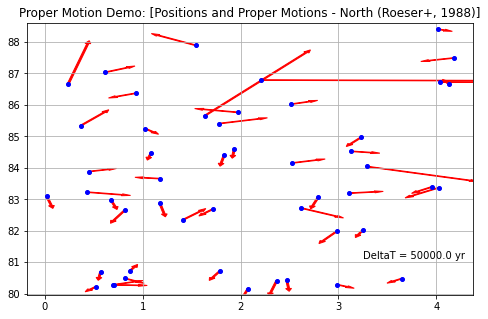

In [4]:
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt

# setup plot
fig = plt.figure(figsize=[8.0, 5.0])
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_title("Proper Motion Demo: [Positions and Proper Motions - North (Roeser+, 1988)]")
ax.set_label("RA ({})".format(positions.coord.ra.unit))
ax.set_label("DEC ({})".format(positions.coord.dec.unit))
ax.set_xlim( np.min(positions.coord.ra.value)-0.2, np.max(positions.coord.ra.value)+0.2 )
ax.set_ylim( np.min(positions.coord.dec.value)-0.2, np.max(positions.coord.dec.value)+0.2 )

# Gather data to plot
xvals = positions.coord.ra.value
yvals = positions.coord.dec.value

deltaT = (50000.0 * u.Unit('yr'))
dx     = (motions.coord.lon * deltaT).to(u.deg).value
dy     = (motions.coord.lat * deltaT).to(u.deg).value

# Plot data
ax.plot( xvals, yvals, markersize=4, marker="o", linestyle='', color="blue")

# Add arrows indicating proper motion direction and scale
ax.text( 3.25, 81.1, "DeltaT = {}".format( deltaT ))
for n in range(len(xvals)):
    ax.arrow( xvals[n], yvals[n], dx[n], dy[n], width=0.02, color="red")


# Save the plot
plt.savefig( "temp/vizier_pm_plot.png" )


### Make Animation of Sources

In [5]:
# define subroutine for updating animation plot
def anime_update( dt, coord, feature ):
    global fig
    global xdata, ydata
    global ln1, ln2, ln3, ln4
    
    if dt == 0:
        # Set/plot initial positions
        xdata = [coord.ra.value]
        ydata = [coord.dec.value]
        
        ln1.set_data( xdata, ydata )
        ln2.set_data( xdata, ydata )
        ln3.set_data( xdata, ydata )
        ln4.set_data( xdata, ydata )
        lnt.set_text("T = To")
    else:
        # Apply proper motion
        deltaT = ( dt * u.Unit('yr'))
        new_coord = coord.apply_space_motion( dt=deltaT ) # << AstroPy PM propogation method
        
        # Add new point and replot
        xdata.append(new_coord.ra.value)
        ydata.append(new_coord.dec.value)
        
        # main window
        ln2.set_data( xdata, ydata )                                # trail
        ln1.set_data( [new_coord.ra.value], [new_coord.dec.value] ) # current location

        # zoom window
        lnt.set_text("T = To + {}".format(deltaT))
        ln4.set_data( xdata, ydata )                                # trail
        ln3.set_data( [new_coord.ra.value], [new_coord.dec.value])  # current location
        
    return ln1, ln2, ln3, ln4
        

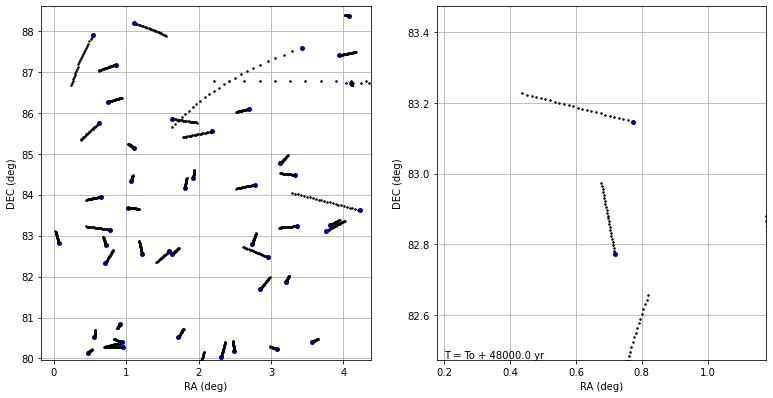

In [6]:
from math import cos, radians
from astropy.coordinates import SkyCoord
from matplotlib.animation import FuncAnimation


# To perform the animation, we need to link the ProperMotion data to the AstroPy SkyCoord positions.

pmx = motions.coord.lon
pmy = motions.coord.lat

# SkyCoord is expecting pm.ra_cos(dec), apply this factor if not already done
if not motions.cos_lat_applied:
    for n in range(len(positions.coord.ra)):
        pmx[n] *= cos(radians(positions.coord.dec.value[n]))

# Create new SkyCoord with both Position and PM data
coord = SkyCoord( positions.coord.ra, positions.coord.dec, pm_ra_cosdec=pmx, pm_dec=pmy, frame=positions.coord.frame )

# Setup plots
fig = plt.figure(figsize=[13.0,6.5])
xdata = []
ydata = []
tdata = []

#   main window
ax1 = plt.subplot(121)
ax1.grid(True)
ax1.set_xlabel("RA ({})".format( coord.ra.unit ))
ax1.set_ylabel("DEC ({})".format( coord.dec.unit ))
ax1.set_xlim( np.min(positions.coord.ra.value)-0.2, np.max(positions.coord.ra.value)+0.2 )
ax1.set_ylim( np.min(positions.coord.dec.value)-0.2, np.max(positions.coord.dec.value)+0.2 )
ln1, = ax1.plot([], [], markersize=4, marker='o', linestyle='', color='blue')
ln2, = ax1.plot([], [], markersize=3, marker='.', linestyle='', color='black')


#  zoom window on feature source
feature = 8
ax2 = plt.subplot(122)
ax2.grid(True)
ax2.set_xlabel("RA ({})".format( coord.ra.unit ))
ax2.set_ylabel("DEC ({})".format( coord.dec.unit ))
ax2.set_xlim( np.min(positions.coord.ra.value[feature])-0.5, np.max(positions.coord.ra.value[feature])+0.5 )
ax2.set_ylim( np.min(positions.coord.dec.value[feature])-0.5, np.max(positions.coord.dec.value[feature])+0.5 )
ln3, = ax2.plot([], [], markersize=4, marker='o', linestyle='', color='blue')
ln4, = ax2.plot([], [], markersize=3, marker='.', linestyle='', color='black')
lnt  = ax2.text( 0.2, 82.5, "T = To", ha="left", va="top")

# Animate
ani = FuncAnimation(fig, anime_update, frames=range(0,50000,2000), fargs=(coord,feature,), interval=500, blit=True)

# Save the animation (gif)
ani.save( "temp/vizier_pm_anime.gif", writer='pillow')
